# Project AI Academy

## Final version 
By Alec Plante, Deanna Hedges, Raul Cortes, Sunny Sanchez, Zachary Mitchell

## Import Libraries


In [177]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import panel as pn
pn.extension('tabulator')

import hvplot.pandas

## Unzip Data
This section is used to unzip data from the zippedData folder and place it into the new data folder

In [77]:
#extract im.db zip file
import zipfile
with zipfile.ZipFile('zippedData/im.db.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

# unzip the gz files 
import gzip
import shutil

# unzip bom.movie_gross
with gzip.open('zippedData/bom.movie_gross.csv.gz', 'rb') as f_in:
    with open('data/bom.movie_gross.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
# unzip rt.movie_info.tsv
with gzip.open('zippedData/rt.movie_info.tsv.gz', 'rb') as f_in:
    with open('data/rt.movie_info.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
# unzip rt.reviews.tsv
with gzip.open('zippedData/rt.reviews.tsv.gz', 'rb') as f_in:
    with open('data/rt.reviews.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
# unzip tmdb.movies.csv
with gzip.open('zippedData/tmdb.movies.csv.gz', 'rb') as f_in:
    with open('data/tmdb.movies.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
# unzip tn.movie_budgets.csv
with gzip.open('zippedData/tn.movie_budgets.csv.gz', 'rb') as f_in:
    with open('data/tn.movie_budgets.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

## Import Data and connect to Database

In [78]:
# import data as...                                                               
movieGross = pd.read_csv('data/bom.movie_gross.csv')                              
tmdbMovies = pd.read_csv('data/tmdb.movies.csv')                                  
movieBudgets = pd.read_csv('data/tn.movie_budgets.csv')                           
movieInfo = pd.read_csv('data/rt.movie_info.tsv', sep = '\t')                     

reviews = pd.read_csv('data/rt.reviews.tsv', sep = '\t', encoding= 'latin1')      

Useful info contained in each dataframe:
 
 * im.db              HAS AVERAGERATING, VOTES, GENRE AND RUNTIME MINUTES
 * movieGross         HAS DOMESTIC_GROSS, FOREIGN_GROSS AND YEAR
 * tmdbMovies         HAS POPULARITY, VOTE_AVERAGE AND VOTE_COUNT
 * movieBudgets       HAS DOMESTIC_GROSS, WORLDWIDE_GROSS AND PRODUCTION BUDGET
 * movieInfo          HAS BOX OFFICE AND GENRE

In [79]:
# Connect to sql database
conn = sqlite3.connect('data/im.db')

## Data Merging

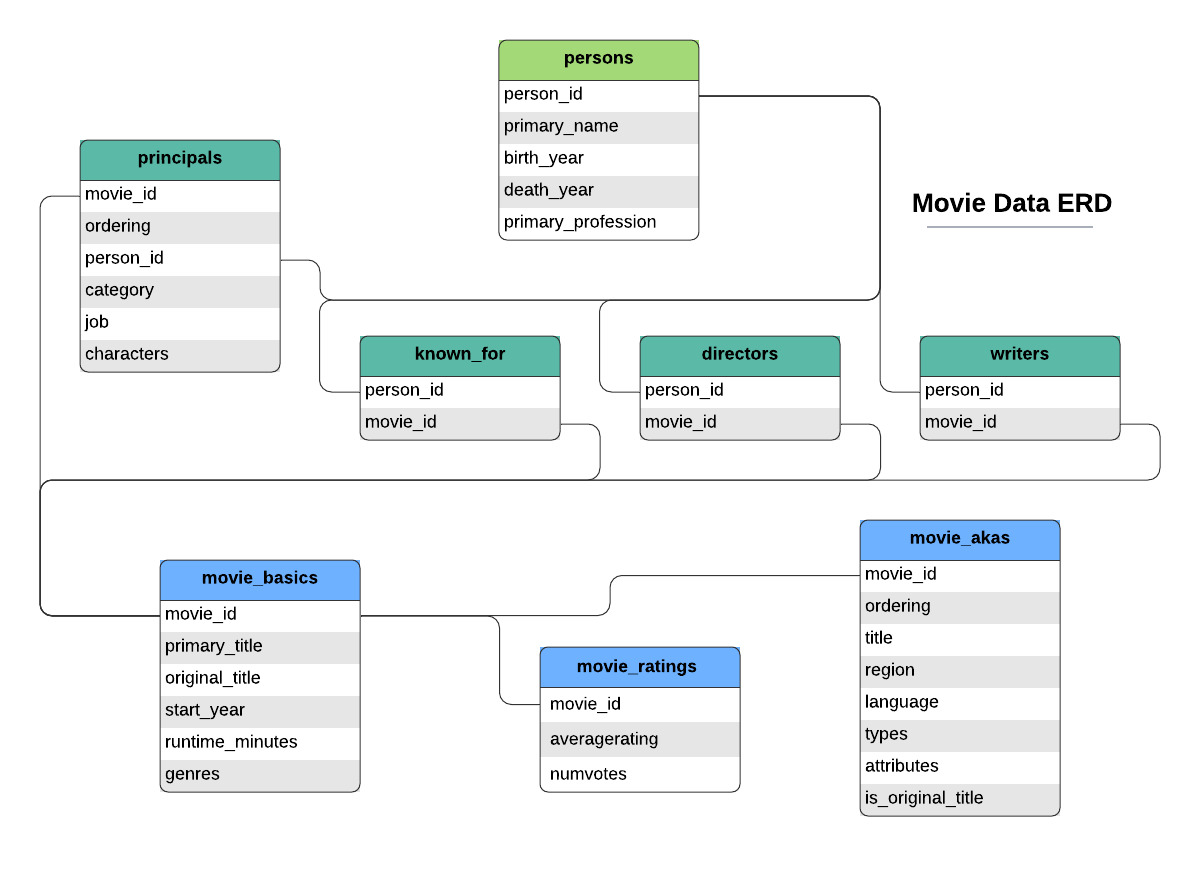

Here we're gonna be adding the necessary data from the database, since we'll be working with reviews...

This will get the writers into Q1

In [80]:
# WRITERS

q1 = pd.read_sql("""

SELECT
    
    r.primary_name,
    b.movie_id
    
FROM

    persons r
    JOIN writers b
        ON r.person_id = b.person_id
        
""", conn)

q1['writer'] = q1['primary_name']
q1 = q1.drop('primary_name', axis = 1)

This will get the directors into Q2

In [81]:
# DIRECTORS

q2 = pd.read_sql("""

SELECT
    
    r.primary_name,
    b.movie_id
    
FROM

    persons r
    JOIN directors b
        ON r.person_id = b.person_id
        
""", conn)

q2['director'] = q2['primary_name']
q2 = q2.drop('primary_name', axis = 1)

Now we will merge directors and writers into the same data set and then with main in Q1

In [82]:
q2 = pd.merge(q1, q2, left_on=['movie_id'], right_on = ['movie_id'])

In [83]:
q1 = pd.read_sql("""

SELECT
    
    r.averagerating,
    r.numvotes,
    r.movie_id,
    b.genres,
    b.original_title,
    b.primary_title,
    b.start_year
    
FROM

    movie_ratings r
    JOIN movie_basics b
        ON r.movie_id = b.movie_id
        
""", conn)

In [84]:
q1 = pd.merge(q1, q2, left_on=['movie_id'], right_on = ['movie_id'])

## Data Cleaning

In [85]:
# First we're gonna see how the data for Reviews is organized to determine types of data per column and unnecessary/problematic
# characters to get rid of

type(reviews)

pandas.core.frame.DataFrame

We're gonna count missing data per dataframe, we'll confirm missing data, count and add it all up

In [86]:
#IM.DB
q1.isna().sum()             #MISSING DATA IN GENRES

averagerating         0
numvotes              0
movie_id              0
genres            19556
original_title        0
primary_title         0
start_year            0
writer                0
director              0
dtype: int64

In [87]:
#REVIEWS
reviews.isna().sum()       #MISSING DATA IN REVIEW, RATING, CRITIC, TOP CRITIC AND PUBLISHER

id                0
review         5563
rating        13517
fresh             0
critic         2722
top_critic        0
publisher       309
date              0
dtype: int64

In [88]:
#MOVIEGROSS
movieGross.isna().sum()    #MISSING DATA IN DOMESTIC GROSS AND FOREIGN GROSS

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [89]:
#TMDBMOVIES
tmdbMovies.isna().sum()    #NO MISSING DATA

Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

In [90]:
#MOVIEBUDGETS
movieBudgets.isna().sum()   #NO MISSING DATA

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [91]:
#INFO
movieInfo.isna().sum()     #MISSING DATA IN SYNOPSIS, RATING, GENRE, DIRECTOR, WRITER, THEATER DATE, DVD DATE, CURRENCY, BOX
                           #OFFICE, RUNTIME AND STUDIO

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

We create a copy of the dataframes which we will modify

In [92]:
reviews2 = reviews.copy()
q2 = q1.copy()
movieGross2 = movieGross.copy()
tmdbMovies2 = tmdbMovies.copy()
movieBudgets2 = movieBudgets.copy()
movieInfo2 = movieInfo.copy()

We fill empty reviews with unavailable chosen string by the team for consistency

In [93]:
reviews2[['review','rating','critic','publisher']] = reviews2[['review','rating','critic','publisher']].fillna('-')
q2['genres'] = q1['genres'].fillna('-')
movieGross2[['domestic_gross', 'foreign_gross']] = movieGross2[['domestic_gross', 'foreign_gross']].fillna('0')
movieGross2['studio'] = movieGross2['studio'].fillna('-')
movieInfo2[['synopsis', 'rating', 'genre', 'director', 'writer', 'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime', 'studio']] = movieInfo2[['synopsis', 'rating', 'genre', 'director', 'writer', 'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime', 'studio']].fillna('-')

Here we confirm missing data has been filled out, count and add it all up missing data, should be 0

In [94]:
reviews2.isna().sum()

id            0
review        0
rating        0
fresh         0
critic        0
top_critic    0
publisher     0
date          0
dtype: int64

In [95]:
q2.isna().sum()

averagerating     0
numvotes          0
movie_id          0
genres            0
original_title    0
primary_title     0
start_year        0
writer            0
director          0
dtype: int64

In [96]:
movieGross2.isna().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

In [97]:
tmdbMovies2.isna().sum()

Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

In [98]:
movieBudgets2.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [99]:
movieInfo2.isna().sum()

id              0
synopsis        0
rating          0
genre           0
director        0
writer          0
theater_date    0
dvd_date        0
currency        0
box_office      0
runtime         0
studio          0
dtype: int64

## Data Preparation

### Reviews2

Here we set the date column to the appropriate format so we can further work on it

In [100]:
reviews2['date'] = pd.to_datetime(reviews2['date'])

Here we can see the new formatting for the date column

In [101]:
reviews2['date'].dtypes

dtype('<M8[ns]')

Here we add new columns for year, days and months

In [102]:
# Month
reviews2['Month'] = reviews2['date'].dt.month
# Day
reviews2['Day'] = reviews2['date'].dt.day
# Year
reviews2['Year'] = reviews2['date'].dt.year

Here we can see which are the values of dates from newest to oldest, Most recent = 2018 and oldest 1800?

In [103]:
reviews2['date'].sort_values(ascending = False)

29476   2018-12-06
45239   2018-12-06
32362   2018-12-06
30438   2018-12-06
29473   2018-12-06
           ...    
4136    1951-10-15
16148   1800-01-01
50023   1800-01-01
13856   1800-01-01
16497   1800-01-01
Name: date, Length: 54432, dtype: datetime64[ns]

Here we check what's one of those 1800s date and we can see its a mistake, therefore we'll be removing these inaccurate logs

In [104]:
display(reviews2.iloc[16497])

id                                                          669
review        Terry Gilliam's third fantasy feature may not ...
rating                                                        -
fresh                                                     fresh
critic                                       Jonathan Rosenbaum
top_critic                                                    1
publisher                                        Chicago Reader
date                                        1800-01-01 00:00:00
Month                                                         1
Day                                                           1
Year                                                       1800
Name: 16497, dtype: object

Here we filter out all data prior to 1900 and confirm the data has been indeed filtered out

In [105]:
reviews2 = reviews2[(reviews2['date'].dt.year > 1900)]

reviews2['Year'].sort_values(ascending = False)

0        2018
33984    2018
33986    2018
33987    2018
33988    2018
         ... 
43963    1965
20142    1958
9665     1953
4137     1951
4136     1951
Name: Year, Length: 54428, dtype: int64

### IM.DB (Q2)

In [106]:
q2['start_year'].sort_values(ascending = False)

0         2019
835537    2019
835507    2019
835506    2019
835505    2019
          ... 
377427    2010
377426    2010
377425    2010
377424    2010
468823    2010
Name: start_year, Length: 46166004, dtype: int64

### MOVIE GROSS 2

Removing commas from numeric columns

In [107]:
#movieGross2['domestic_gross'] = movieGross2['domestic_gross'].str.replace(',','')
movieGross2['foreign_gross'] = movieGross2['foreign_gross'].str.replace(',','')

Setting the right formatting for the numeric columns

In [108]:
movieGross2['domestic_gross'] = movieGross2['domestic_gross'].astype(float)
movieGross2['foreign_gross'] = movieGross2['foreign_gross'].astype(float)

### tmdbMovies 2

Setting the right formatting for the dataframe's columns

In [109]:
tmdbMovies2['popularity'] = tmdbMovies2['popularity'].astype(float)
tmdbMovies2['vote_average'] = tmdbMovies2['vote_average'].astype(float)
tmdbMovies2['vote_count'] = tmdbMovies2['vote_count'].astype(float)
tmdbMovies2['id'] = tmdbMovies2['id'].astype(int)
tmdbMovies2['release_date'] = pd.to_datetime(tmdbMovies2['release_date'])

### movieBudgets 2

Removing commas and special characters from numeric columns

In [110]:
movieBudgets2['domestic_gross'] = movieBudgets2['domestic_gross'].str.replace(',','')
movieBudgets2['domestic_gross'] = movieBudgets2['domestic_gross'].replace({'\$':''}, regex = True)
movieBudgets2['worldwide_gross'] = movieBudgets2['worldwide_gross'].str.replace(',','')
movieBudgets2['worldwide_gross'] = movieBudgets2['worldwide_gross'].replace({'\$':''}, regex = True)
movieBudgets2['production_budget'] = movieBudgets2['production_budget'].str.replace(',','')
movieBudgets2['production_budget'] = movieBudgets2['production_budget'].replace({'\$':''}, regex = True)

Setting the right formatting for the numeric and date columns

In [111]:
movieBudgets2['domestic_gross'] = movieBudgets2['domestic_gross'].astype(float)
movieBudgets2['worldwide_gross'] = movieBudgets2['worldwide_gross'].astype(float)
movieBudgets2['production_budget'] = movieBudgets2['production_budget'].astype(float)
movieBudgets2['release_date'] = pd.to_datetime(movieBudgets2['release_date'])

### movieInfo 2

Setting the right formatting for the dataframe's date columns

In [112]:
# Removing the minutes word from the data
movieInfo2['runtime'] = movieInfo2['runtime'].replace({'minutes':''}, regex = True)    #THIS COLUMN IS IN MINUTES! REMINDER!!!

# ADJUSTING THE DATES TO ACCEPTABLE FORMAT

# THEATER_DATE
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Jan':'01 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Feb':'02 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Mar':'03 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Apr':'04 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'May':'05 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Jun':'06 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Jul':'07 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Aug':'08 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Sep':'09 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Oct':'10 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Nov':'11 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Dec':'12 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({',':' -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({' ':''}, regex = True)
movieInfo2 = movieInfo2[(movieInfo2['theater_date'] != '-')]
movieInfo2['theater_date'] = pd.to_datetime(movieInfo2['theater_date'])

# DVD_DATE
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Jan':'01 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Feb':'02 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Mar':'03 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Apr':'04 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'May':'05 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Jun':'06 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Jul':'07 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Aug':'08 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Sep':'09 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Oct':'10 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Nov':'11 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Dec':'12 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({',':' -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({' ':''}, regex = True)
movieInfo2 = movieInfo2[(movieInfo2['dvd_date'] != '-')]
movieInfo2['dvd_date'] = pd.to_datetime(movieInfo2['dvd_date'])

# BOX OFFICE
movieInfo2 = movieInfo2[(movieInfo2['box_office'] != '-')]
movieInfo2['box_office'] = movieInfo2['box_office'].str.replace(',','')
movieInfo2['box_office'] = movieInfo2['box_office'].astype(float)

# RUNTIME
movieInfo2 = movieInfo2[(movieInfo2['runtime'] != '-')]
movieInfo2['runtime'] = movieInfo2['runtime'].astype(int)

### tmdbMovies2

Removing unnecessary column and order columns

In [113]:
tmdbMovies2 = tmdbMovies2.drop('Unnamed: 0', axis = 1)
new_cols = ["id", "genre_ids", "title", "original_title", "popularity", "release_date", "vote_average", "vote_count", "original_language"]
tmdbMovies2 = tmdbMovies2.reindex(columns=new_cols)

### Here we're gonna work on combining dataframes to get precise results

We'll be merging all datasets to get one for our visualizations

In [260]:
movdf1 = pd.merge(movieGross2, tmdbMovies2, left_on = ['title'], right_on = ['title'])
movdf1 = pd.merge(movieBudgets2, movdf1, left_on = ['movie','release_date'], right_on = ['title','release_date'])
movdf1 = pd.merge(q2, movdf1, left_on=['original_title','primary_title'], right_on = ['original_title','title'])

movdf2 = pd.merge(reviews2, movieInfo2, left_on=['id'], right_on = ['id'])

### Quick clean of new tables

Now we're gonna remove duplicates from this final dataset

In [115]:
movdf2['review'] = movdf2['review'].str.replace('-','False')
movdf2 = movdf2.drop_duplicates(subset = 'review', keep = False)

We switched our - to false so we could keep them during our cleaning

In [116]:
movdf2['review'] = movdf2['review'].str.replace('False','-')

Let's create a copy remove useless columns for our purpose

In [117]:
movdf3 = movdf2.copy()

We'll calculate total gross to use on ROI

In [118]:
movdf3['total_gross'] = movdf3['domestic_gross_y'] + movdf3['foreign_gross']

We'll calculate ROI

In [119]:
movdf3['ROI'] = (movdf3['total_gross'] / movdf3['production_budget'])*100

In [280]:
movdf2 = movdf2.drop('Year', axis = 1)
movdf2 = movdf2.drop('Month', axis = 1)
movdf2 = movdf2.drop('Day', axis = 1)

Now let's remove useless columns for our purpose

In [120]:
#movdf2 = movdf2.drop('synopsis', axis = 1)
movdf3 = movdf3.drop('id_y', axis = 1)
movdf3 = movdf3.drop('genre_ids', axis = 1)
movdf3 = movdf3.drop('top_critic', axis = 1)
movdf3 = movdf3.drop('Year', axis = 1)
movdf3 = movdf3.drop('year', axis = 1)
movdf3 = movdf3.drop('Month', axis = 1)
movdf3 = movdf3.drop('Day', axis = 1)
movdf3 = movdf3.drop('domestic_gross_x', axis = 1)
movdf3 = movdf3.drop('domestic_gross_y', axis = 1)
movdf3 = movdf3.drop('foreign_gross', axis = 1)
movdf3 = movdf3.drop('original_language', axis = 1)
movdf3 = movdf3.drop('production_budget', axis = 1)
movdf3 = movdf3.drop('title', axis = 1)
movdf3 = movdf3.drop('synopsis', axis = 1)
movdf3 = movdf3.drop('review', axis = 1)
movdf3 = movdf3.drop('rating_x', axis = 1)
movdf3 = movdf3.drop('rating_y', axis = 1)
movdf3 = movdf3.drop('id_x', axis = 1)
movdf3 = movdf3.drop('worldwide_gross', axis = 1)
movdf3 = movdf3.drop('theater_date', axis = 1)
movdf3 = movdf3.drop('dvd_date', axis = 1)
movdf3 = movdf3.drop('start_year', axis = 1)
movdf3 = movdf3.drop('release_date', axis = 1)
movdf3 = movdf3.drop('date', axis = 1)
movdf3 = movdf3.drop('total_gross', axis = 1)
movdf3 = movdf3.drop('writer', axis = 1)
movdf3 = movdf3.drop('currency', axis = 1)
movdf3 = movdf3.drop('original_title', axis = 1)
movdf3 = movdf3.drop('primary_title', axis = 1)
movdf3 = movdf3.drop('movie_id', axis = 1)
movdf3 = movdf3.drop('studio_y', axis = 1)
movdf3 = movdf3.drop('genre', axis = 1)
movdf3 = movdf3.drop('popularity', axis = 1)

Renaming our columns to make it easier to process

In [121]:
movdf3['numvotes1'] = movdf3['numvotes']
movdf3 = movdf3.drop('numvotes', axis = 1)
movdf3['avgrating1'] = movdf3['averagerating']
movdf3 = movdf3.drop('averagerating', axis = 1)
movdf3['avgrating2'] = movdf3['vote_average']
movdf3 = movdf3.drop('vote_average', axis = 1)
movdf3['numvotes2'] = movdf3['vote_count']
movdf3 = movdf3.drop('vote_count', axis = 1)
movdf3['studio'] = movdf3['studio_x']
movdf3 = movdf3.drop('studio_x', axis = 1)

Organizing columns in an order that's best suited for our analysis

In [122]:
new_cols = ["id","movie","genres","runtime","director","studio","critic","fresh","publisher","numvotes1","avgrating1","numvotes2","avgrating2","ROI","box_office"]
movdf3 = movdf3[new_cols]

## Data Exploration

#### This is the final dataset we'll be working with for everything from here on

In [224]:
movdf1.drop_duplicates(subset='primary_title')

,averagerating,numvotes,movie_id,genres,original_title,primary_title,start_year,writer,director,id_x,...,studio,domestic_gross_y,foreign_gross,year,id_y,genre_ids,popularity,vote_average,vote_count,original_language
0,4.2,50352,tt1043726,"Action,Adventure,Fantasy",The Legend of Hercules,The Legend of Hercules,2014,Giulio Steve,Renny Harlin,42,...,LG/S,18800000.0,42400000.0,2014,188207,"[28, 12]",13.754,4.5,805.0,en
16,5.1,8296,tt1171222,Comedy,Baggage Claim,Baggage Claim,2013,David E. Talbert,David E. Talbert,38,...,FoxS,21600000.0,887000.0,2013,175528,[35],8.666,5.4,127.0,en
17,5.4,54646,tt1243974,"Comedy,Drama,Romance",Aloha,Aloha,2015,Cameron Crowe,Cameron Crowe,3,...,Sony,21100000.0,5200000.0,2015,222936,"[18, 35, 10749]",9.685,5.3,1226.0,en
18,4.4,69199,tt1261945,"Comedy,Drama,Romance",Sex and the City 2,Sex and the City 2,2010,Michael Patrick King,Michael Patrick King,16,...,WB (NL),95300000.0,193000000.0,2010,37786,"[35, 18, 10749]",9.986,5.9,809.0,en
27,6.3,54421,tt1322312,"Comedy,Romance",Going the Distance,Going the Distance,2010,Geoff LaTulippe,Nanette Burstein,11,...,WB (NL),17800000.0,24200000.0,2010,38073,"[35, 18, 10749]",8.281,6.0,394.0,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88939,4.4,5648,tt2166214,"Action,Comedy",Khiladi 786,Khiladi 786,2012,Himesh Reshammiya,Ashish R. Mohan,12,...,Eros,379000.0,0.0,2012,147767,"[28, 35]",1.824,4.7,16.0,en
88948,6.1,156432,tt2333784,"Action,Adventure,Thriller",The Expendables 3,The Expendables 3,2014,Sylvester Stallone,Patrick Hughes,96,...,LGF,39300000.0,175300000.0,2014,138103,"[28, 12, 53]",18.797,6.1,2876.0,en
88964,5.6,74979,tt2592614,"Action,Horror,Sci-Fi",Resident Evil: The Final Chapter,Resident Evil: The Final Chapter,2016,Paul W.S. Anderson,Paul W.S. Anderson,84,...,SGem,26800000.0,285400000.0,2017,173897,"[28, 27, 878]",0.844,5.9,1859.0,en
88965,7.0,163279,tt2704998,"Action,Comedy,Crime",Game Night,Game Night,2018,Mark Perez,Jonathan Goldstein,94,...,WB (NL),69200000.0,48500000.0,2018,445571,"[9648, 35, 80]",19.459,6.9,2756.0,en


### Creating lists to explore the data

First thing we want is to get an idea on how much is each publisher posting fresh/rotten reviews and see the ones that are participating in reviewing the most.

Creating a table of FRESH-ROTTEN / PUBLISHER and how many reviews they made

##### [1]

In [208]:
pub_f = pd.DataFrame()
pub_f['fresh'] = movdf3['fresh']
pub_f['publisher'] = movdf3['publisher']
pub_f = pub_f.drop_duplicates(subset = 'publisher')
pub_f['count_pub'] = movdf3.groupby('publisher')['publisher'].transform('count')


pub_f = pub_f.sort_values("count_pub", ascending=False)[:20]
pub_f
#pub_f['count_pub'].sort_values(ascending=False)[:]

,fresh,publisher,count_pub
5866,fresh,-,11
3166,fresh,eFilmCritic.com,10
5976,fresh,Guardian,10
5929,rotten,Reeling Reviews,9
5952,fresh,Time Out,8
3204,fresh,Detroit News,7
3196,fresh,Entertainment Weekly,7
5915,fresh,Kaplan vs. Kaplan,7
5967,fresh,London Evening Standard,7
3189,fresh,New York Times,7


Secondly, we want to see how much does the data results reflect on, based on the most participating individuals (critics) per publisher.

Creating a table of CRITIC / FRESH / PUBLISHER

##### [2]

In [209]:
crt_fp = pd.DataFrame()
crt_fp['critic'] = movdf3['critic']
crt_fp['fresh'] = movdf3['fresh']
crt_fp['publisher'] = movdf3['publisher']
crt_fp = crt_fp.drop_duplicates(subset = 'publisher')
crt_fp['count_crt'] = movdf3.groupby('critic')['critic'].transform('count')
#crt_fp['count_crt'].sort_values(ascending=False)[:]

Thirdly, we want to see if there's any evidence of there being a bias on the reviews based on a director or the studio individually.

Creating a table of DIRECTOR / STUDIO / FRESH

##### [3]

In [159]:
ds_f = pd.DataFrame()
ds_f['director'] = movdf3['director']
ds_f['studio'] = movdf3['studio']
ds_f['fresh'] = movdf3['fresh']
ds_f['count_f'] = movdf3.groupby('fresh')['fresh'].transform('count')
#crt_fp['count_crt'].sort_values(ascending=False)[:]

Now we want to gain insight on how much does the reviews from critics diverge from those of the general public

Creating a table of MOVIE / AVG RATING 1 / AVG RATING 2 / FRESH

##### [4]

In [161]:
mar_f = pd.DataFrame()
mar_f['movie'] = movdf3['movie']
mar_f['avgr1'] = movdf3['avgrating1']
mar_f['avgr2'] = movdf3['avgrating2']
mar_f['fresh'] = movdf3['fresh']

Finally, we get to see how this reflects on how well or poorly did a movie do (financially) and if this reflects reviews

Creating a table of MOVIE / AVG RATING / FRESH / ROI

##### [5]

In [181]:
mrf_r = pd.DataFrame()
mrf_r['movie'] = movdf3['movie']
mrf_r['avgr1'] = movdf3['avgrating1']
mrf_r['fresh'] = movdf3['fresh']
mrf_r['ROI'] = movdf3['ROI']

#mrf_r['ROI'].sort_values(ascending=False)[:]

## Data Visualization

### Preparing the data

Firstly we're gonna visualize the datasets we built previously to understand our data and reach conclusions

##### Box Office Performance vs Freshness 

Text(0.5, 1.0, 'Box Office Performance')

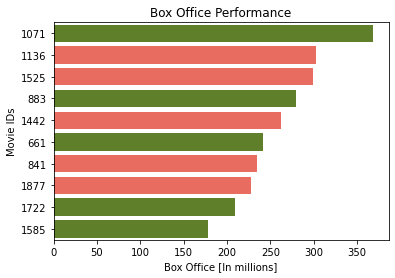

In [368]:
movdf2= movdf2.drop_duplicates('id')
movdf2Sort = movdf2.sort_values(by = 'box_office', ascending=False)[:10]

col = ['#648D1C','#FF5948','#FF5948','#648D1C','#FF5948','#648D1C','#FF5948','#FF5948','#648D1C','#648D1C']
sns.set_palette(sns.color_palette(col))

movdf2Sort['box_office'] = movdf2Sort['box_office']/1000000
movdf2Sort['id'] = movdf2Sort['id'].astype(str)
bo_f = sns.barplot(x=movdf2Sort['box_office'],y = movdf2Sort['id'])

bo_f.set(xlabel='Box Office [In millions]', ylabel='Movie IDs')
bo_f.set_title('Box Office Performance')

##### Movie Earnings vs Reviews

Text(0.5, 1.0, 'Top 10 Highest Grossing Movie Titles')

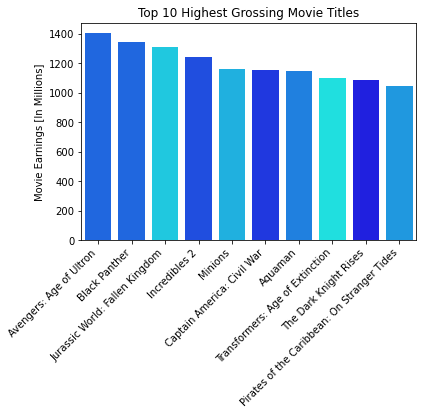

In [366]:
movdf5 = movdf1.copy()
movdf5 = movdf5.drop_duplicates('movie_id')
movdf5.sort_values(by = 'domestic_gross_y', ascending=False)[:10]
movdf6 = pd.DataFrame()
movdf5['total_gross'] = (movdf5['domestic_gross_y'] + movdf5['foreign_gross'])/1000000

movdf5Sort = movdf5.sort_values(by = 'total_gross', ascending=False)[:10]

col = ['#005FFF','#005FFF','#00E0FF','#003EFF','#00C0FF','#0020FF','#0080FF','#00FFFF','#0000FF','#00A0FF']
sns.set_palette(sns.color_palette(col))


mov_rg = sns.barplot(x=movdf5Sort['primary_title'] ,y = movdf5Sort['total_gross'])

mov_rg.set_xticklabels(mov_rg.get_xticklabels(), rotation=45, horizontalalignment='right')

mov_rg.set(xlabel='', ylabel='Movie Earnings [In Millions]')
mov_rg.set_title('Top 10 Highest Grossing Movie Titles')

In [350]:
movdf5Sort

,averagerating,numvotes,movie_id,genres,original_title,primary_title,start_year,writer,director,id_x,...,domestic_gross_y,foreign_gross,year,id_y,genre_ids,popularity,vote_average,vote_count,original_language,total_gross
87354,7.3,665594,tt2395427,"Action,Adventure,Sci-Fi",Avengers: Age of Ultron,Avengers: Age of Ultron,2015,Jack Kirby,Joss Whedon,4,...,459000000.0,946400000.0,2015,99861,"[28, 12, 878]",44.383,7.3,13457.0,en,1405.4
6072,7.3,516148,tt1825683,"Action,Adventure,Sci-Fi",Black Panther,Black Panther,2018,Jack Kirby,Ryan Coogler,42,...,700100000.0,646900000.0,2018,284054,"[28, 12, 14, 878]",44.140,7.4,12365.0,en,1347.0
5632,6.2,219125,tt4881806,"Action,Adventure,Sci-Fi",Jurassic World: Fallen Kingdom,Jurassic World: Fallen Kingdom,2018,Michael Crichton,J.A. Bayona,13,...,417700000.0,891800000.0,2018,351286,"[28, 12, 878]",34.958,6.5,5995.0,en,1309.5
83830,7.7,203510,tt3606756,"Action,Adventure,Animation",Incredibles 2,Incredibles 2,2018,Brad Bird,Brad Bird,44,...,608600000.0,634200000.0,2018,260513,"[28, 12, 16, 10751]",36.286,7.6,6354.0,en,1242.8
83027,6.4,193917,tt2293640,"Adventure,Animation,Comedy",Minions,Minions,2015,Brian Lynch,Kyle Balda,73,...,336000000.0,823400000.0,2015,211672,"[10751, 16, 12, 35]",9.338,6.4,7343.0,en,1159.4
86195,7.8,583507,tt3498820,"Action,Adventure,Sci-Fi",Captain America: Civil War,Captain America: Civil War,2016,Jack Kirby,Joe Russo,17,...,408100000.0,745200000.0,2016,271110,"[12, 28, 878]",39.137,7.4,14000.0,en,1153.3
84435,7.1,263328,tt1477834,"Action,Adventure,Fantasy",Aquaman,Aquaman,2018,David Leslie Johnson-McGoldrick,James Wan,36,...,335100000.0,812700000.0,2018,297802,"[28, 12, 14]",38.102,6.8,6155.0,en,1147.8
80744,5.7,283486,tt2109248,"Action,Adventure,Sci-Fi",Transformers: Age of Extinction,Transformers: Age of Extinction,2014,Ehren Kruger,Michael Bay,37,...,245400000.0,858600000.0,2014,91314,"[878, 28, 12]",20.961,5.8,4805.0,en,1104.0
5762,8.4,1387769,tt1345836,"Action,Thriller",The Dark Knight Rises,The Dark Knight Rises,2012,Christopher Nolan,Christopher Nolan,11,...,448100000.0,636800000.0,2012,49026,"[28, 80, 18, 53]",26.220,7.7,13933.0,en,1084.9
4125,6.6,447624,tt1298650,"Action,Adventure,Fantasy",Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,Terry Rossio,Rob Marshall,2,...,241100000.0,804600000.0,2011,1865,"[12, 28, 14]",30.579,6.4,8571.0,en,1045.7


### WORK IN PROGRESS / CODE TESTING

In [369]:
#Graphing most popular movies
# mp_t1.plot.barh(x='title', y='popularity', title='Most Popular Movies', color='blue')
#movdf3 = movdf1.drop_duplicates(subset='primary_title')
#movdf4 = movdf3.sort_values(by='domestic_gross_y', axis=0, ascending = False)[:20]
#movdf4.columns
#movdf4['fresh'] = movdf4['averagerating'].map(lambda x: x>6)
#movdf4
# movieROI
#sns.barplot(y=movdf4['primary_title'], x=movdf4['domestic_gross_y'], hue= movdf4['averagerating'])